# Branches dataset

### ideas/todo:
- NER with HTML: https://webstruct.readthedocs.io/en/latest/

In [1]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ujson as json

In [2]:
INDUSTRY_CODES_PATH = "Branchen/linkedin-industry-codes.json"
TRAIN_PATH_JSON = "Branchen/data/train.ndjson"
TEST_PATH_JSON = "Branchen/data/test.ndjson"
TRAIN_PATH_CSV = "Branchen/data/train.csv"
TEST_PATH_CSV = "Branchen/data/test.csv"

[Jump to CSV loading](#1)

## Load datasets into dataframes

Dataframe structure:
- `text`: plain text of page, extracted with https://github.com/TeamHG-Memex/html-text
- `html`: HTML of the page
- `industry`: industry code of LinkedIn, i.e. the class
- `country`: country of the website, derived from Top-Level-Domain (if possible)

#### load train

In [3]:
%%time
# loading code taken from: https://stackoverflow.com/questions/63501251/how-to-open-ndjson-file-in-python
train_records = map(json.loads, open(TRAIN_PATH_JSON))
train = pd.DataFrame.from_records(train_records)

CPU times: user 39.9 s, sys: 11.1 s, total: 51 s
Wall time: 1min 18s


#### load test

In [4]:
%%time
test_records = map(json.loads, open(TEST_PATH_JSON))
test = pd.DataFrame.from_records(test_records)

CPU times: user 11.2 s, sys: 3.31 s, total: 14.5 s
Wall time: 22.6 s


In [5]:
print(train.shape)
print(test.shape)

(14374, 4)
(3594, 4)


In [6]:
train.head(5)

,text,html,industry,country
0,Home | NETZkultur GmbH\n\nZum Inhalt wechseln\...,"<!DOCTYPE html>\n<html lang=""de-DE"">\n<head>\n...",4,DE
1,"\n\nNXP Semiconductors | Automotive, Security,...",<!DOCTYPE html>\n<html>\n<head>\n\t<title>NXP ...,7,
2,Suer Nutzfahrzeugtechnik Onlineshop\n\nSie wis...,"<!DOCTYPE html>\n<html lang=""de"">\n <head>\...",53,DE
3,Improve cash flows and long-term profitability...,"\n<!DOCTYPE html>\n<html lang=""en"" prefix=""og:...",43,
4,Your specialist for plastic compounds\n\nMenu ...,"<!DOCTYPE html>\n<html xmlns:og=""http://ogp.me...",117,


### load industry name by code

In [7]:
with open(INDUSTRY_CODES_PATH) as f:
    industry_codes = json.load(f)
    
def get_code(code_list, identifier):
    name = ""
    for entry in code_list:
        if entry["Code"] == identifier:
            name = entry["Description"]
            break
    return name

In [8]:
train["industry_name"] = list(map(lambda x: get_code(industry_codes, x), dict(train["industry"]).values()))

In [9]:
train.head()

,text,html,industry,country,industry_name
0,Home | NETZkultur GmbH\n\nZum Inhalt wechseln\...,"<!DOCTYPE html>\n<html lang=""de-DE"">\n<head>\n...",4,DE,Computer Software
1,"\n\nNXP Semiconductors | Automotive, Security,...",<!DOCTYPE html>\n<html>\n<head>\n\t<title>NXP ...,7,,Semiconductors
2,Suer Nutzfahrzeugtechnik Onlineshop\n\nSie wis...,"<!DOCTYPE html>\n<html lang=""de"">\n <head>\...",53,DE,Automotive
3,Improve cash flows and long-term profitability...,"\n<!DOCTYPE html>\n<html lang=""en"" prefix=""og:...",43,,Financial Services
4,Your specialist for plastic compounds\n\nMenu ...,"<!DOCTYPE html>\n<html xmlns:og=""http://ogp.me...",117,,Plastics


### remove empty text, html, industry and industry_name cols

In [55]:
train.shape

(14374, 5)

In [56]:
train = train.drop(train[train['text'] == ''].index)
train = train.drop(train[train['html'] == ''].index)
train = train.drop(train[train['industry_name'] == ''].index)

In [58]:
# NULL/NaN industry entry?
train.industry.isnull().sum()

0

In [59]:
train.shape

(13114, 5)

Same for test

In [60]:
test.shape

(3594, 4)

In [63]:
# same for test
test = test.drop(test[test['text'] == ''].index)
test = test.drop(test[test['html'] == ''].index)

In [67]:
# NULL/NaN industry entry?
test.industry.isnull().sum()

0

In [68]:
test.shape

(3573, 4)

## Save train/test to csv

In [69]:
train.to_csv(TRAIN_PATH_CSV, index=False)
test.to_csv(TEST_PATH_CSV, index=False)

# Load csv <a class="anchor" id="1"/>

In [70]:
%%time
train = pd.read_csv(TRAIN_PATH_CSV)
test = pd.read_csv(TEST_PATH_CSV)

train.head(2)

CPU times: user 36.8 s, sys: 9.48 s, total: 46.3 s
Wall time: 51.3 s


,text,html,industry,country,industry_name
0,Home | NETZkultur GmbH\n\nZum Inhalt wechseln\...,"<!DOCTYPE html>\n<html lang=""de-DE"">\n<head>\n...",4,DE,Computer Software
1,"\n\nNXP Semiconductors | Automotive, Security,...",<!DOCTYPE html>\n<html>\n<head>\n\t<title>NXP ...,7,NaN,Semiconductors


# Train dataset insights

- all columns have the same non-null values as the shape
- exception: "country" &rarr; about 62% have non-null values

In [73]:
8144/13114

0.6210157084032332

In [72]:
train.shape

(13114, 5)

In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13114 entries, 0 to 13113
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           13114 non-null  object
 1   html           13114 non-null  object
 2   industry       13114 non-null  int64 
 3   country        8144 non-null   object
 4   industry_name  13114 non-null  object
dtypes: int64(1), object(4)
memory usage: 512.4+ KB


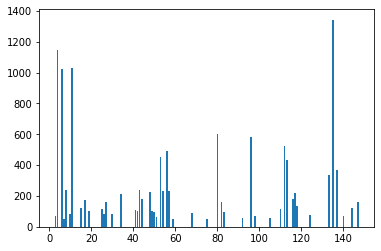

In [74]:
industry_col = dict(train.industry.value_counts())

SORT_KEYS = False
keys = industry_col.keys()
if SORT_KEYS:
    keys = list(map(lambda x: "i"+str(x), industry_col.keys()))
plt.bar(keys, industry_col.values())
plt.show()

## HTML parsing

### Example instance

In [84]:
html0 = train.html.iloc[0]
text0 = train.text.iloc[0]

print(text0[:20], "...")

Home | NETZkultur Gm ...


In [86]:
print(html0[:20], "...")

<!DOCTYPE html>
<htm ...


In [87]:
soup = BeautifulSoup(html0, 'html.parser')

In [88]:
print("Title: \n ", soup.title, "\n ", soup.title.name, "\n ", soup.title.string, "\n ", soup.title.parent.name)
print()

Title: 
  <title>Home | NETZkultur GmbH</title> 
  title 
  Home | NETZkultur GmbH 
  head



### Count HTMLs with `<address>`-Tag

only 524 of 13114 HTML pages have `address`-Tag (~4%)

In [89]:
counter = 0
for index, row in train.iterrows():
    html = row.html
    try:
        soup = BeautifulSoup(html, 'html.parser')
        if soup.address is not None:
            #print(soup.address)
            counter += 1
    except:
        print(row)
        break

In [94]:
print(counter)

524


In [97]:
train.head()

,text,html,industry,country,industry_name
0,Home | NETZkultur GmbH\n\nZum Inhalt wechseln\...,"<!DOCTYPE html>\n<html lang=""de-DE"">\n<head>\n...",4,DE,Computer Software
1,"\n\nNXP Semiconductors | Automotive, Security,...",<!DOCTYPE html>\n<html>\n<head>\n\t<title>NXP ...,7,NaN,Semiconductors
2,Suer Nutzfahrzeugtechnik Onlineshop\n\nSie wis...,"<!DOCTYPE html>\n<html lang=""de"">\n <head>\...",53,DE,Automotive
3,Improve cash flows and long-term profitability...,"\n<!DOCTYPE html>\n<html lang=""en"" prefix=""og:...",43,NaN,Financial Services
4,Your specialist for plastic compounds\n\nMenu ...,"<!DOCTYPE html>\n<html xmlns:og=""http://ogp.me...",117,NaN,Plastics
